Menginstall kaggle supaya bisah memakai kaggle api

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


memakai kaggle api dengan mengimport kaggle.json akun

In [2]:
! chmod 600 /content/kaggle.json

memanggil kaggle api dataset

In [3]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d census/population-time-series-data

  0% 0.00/8.04k [00:00<?, ?B/s]
100% 8.04k/8.04k [00:00<00:00, 8.32MB/s]


Mengextrak dataset dari format zip

In [4]:
import os
import zipfile

zip_r = zipfile.ZipFile("/content/population-time-series-data.zip", "r")
zip_r.extractall()
zip_r.close()

Mengimpor semua library yang di pakai

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

Membaca dataset dengan menggunakan library pandas

In [6]:
df = pd.read_csv("/content/POP.csv")

memanggil sebagaian dataset(5 teratas)

In [7]:
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


Jumlah keseluruhan data ada 816 dan 4 kolom

dengan masing kolom realtime,value,date,realtime_end

# **Data expolarations**

mengecek jumlah keselurahan dataset dan berapa kolom

In [8]:
df.shape

(816, 4)

mengecek kolom numerik(value) berapa countnya,mean,std,min,25%,50%,75%,dan max nya nilai dari kolom value

In [9]:
df.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


dataset tidak memiliki missing value

In [10]:
x = (df.value == 0).sum()
y = df.isnull().sum()

print("nilai 0 di kolom value:", x)
print("nilai null di dataset:", y)

nilai 0 di kolom value: 0
nilai null di dataset: realtime_start    0
value             0
date              0
realtime_end      0
dtype: int64


Dataset tidak memiliki outlinear

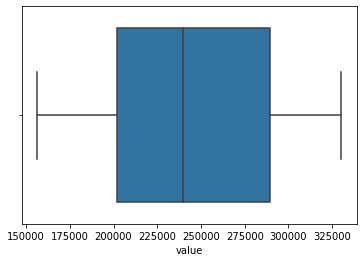

In [11]:
sns.boxplot(x = df["value"])

Mengecek tipe data setiap kolom

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   realtime_start  816 non-null    object 
 1   value           816 non-null    float64
 2   date            816 non-null    object 
 3   realtime_end    816 non-null    object 
dtypes: float64(1), object(3)
memory usage: 25.6+ KB


mnerubah type data kolom date menjadi date time

In [13]:
df["date"] = pd.to_datetime(df["date"])

Membuat visualisasi dataset dengan x nya date dan y nya value

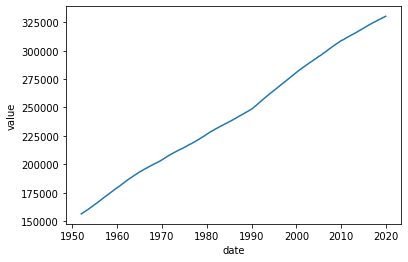

In [14]:
sns.lineplot(x="date", y="value", data=df)

 # **Data preprocessing**

membuat windowed dengan memakai cara function untuk memudahkan nantinya

In [15]:
def windowed_dataset(target, window=1, offset=0):
    feature_new, target_new = [], []
    target_np = target.to_numpy()
    for index in range(window, target.shape[0] - offset):
        feature_new.append(target_np[index - window: index])
        target_new.append(target_np[index+offset])
    return np.array(feature_new), np.array(target_new)


windowed_dataset digunakan untuk membuat deret waktu berdasarkan kolom target yang kita inginkan. Ini mengasumsikan data sudah diurutkan berdasarkan tanggal dan nilainya bukan nol

In [16]:
df = df.sort_values(by=['date'])
window = 5
feature, target = windowed_dataset(df['value'], window=window)
print(feature[0])
print(target[0])
print(df.head(6))

[156309. 156527. 156731. 156943. 157140.]
157343.0
  realtime_start     value       date realtime_end
0     2019-12-06  156309.0 1952-01-01   2019-12-06
1     2019-12-06  156527.0 1952-02-01   2019-12-06
2     2019-12-06  156731.0 1952-03-01   2019-12-06
3     2019-12-06  156943.0 1952-04-01   2019-12-06
4     2019-12-06  157140.0 1952-05-01   2019-12-06
5     2019-12-06  157343.0 1952-06-01   2019-12-06


Melakukan standarisasi dengan metode scaler

Melakukan standart scaler feature untuk mendapatkan hasil terbaik di model

In [17]:
#scaler faeture
scaler_feature = StandardScaler()
feature_shape = feature.shape
feature_scaled = scaler_feature.fit_transform(feature)
feature_scaled[0]

array([-1.73366182, -1.73364508, -1.73390782, -1.73401296, -1.73441917])

Melakukan standart scaler target untuk mendapatkan hasil terbaik di model

In [18]:
#scaler target
scaler_target = StandardScaler()
target_scaled = scaler_target.fit_transform(target.reshape(-1,1))
target_scaled[0: 5]

array([[-1.73471032],
       [-1.7305251 ],
       [-1.72564235],
       [-1.7205603 ],
       [-1.71551811]])

Membagi dataset dengan perbandingan 8:2 dengan 8 data train dan 2 data test

In [19]:
def train_test(feature, target, perc_train = 0.8):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test
    
x_train, x_test, y_train, y_test = train_test(feature_scaled, target_scaled)

Visualisai dataset yang telah di bagi anatara data training dan data test

Text(0.5, 0, 'Date')

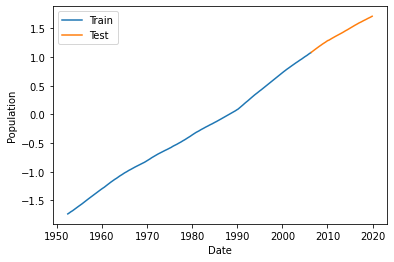

In [20]:
sns.lineplot(x=df['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['date'].iloc[len(y_train) + window:], y=y_test[:,0], label='Test')
plt.ylabel('Population')
plt.xlabel('Date')

# **Model Development**

Dalam development saya akan memakai algoritma 
1.   Neural Network Regression
2.   Linear Regression
3.   SVR

1. Neural Network Regression(LSTM)

model menggunakan sequntial dengan 5 layer

In [21]:
x_train, X_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(units=1))

model.compile(loss='mean_squared_error',
              optimizer='RMSProp',
              metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 83,201
Trainable params: 83,201
Non-trainable params: 0
_________________________________________________________________


melakukan data pelatihan

In [22]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
21/21 [==============================] - 8s 29ms/step - loss: 0.1119 - mae: 0.2092 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0175 - mae: 0.0922 - val_loss: 0.0143 - val_mae: 0.1158
Epoch 3/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0135 - mae: 0.0829 - val_loss: 0.0353 - val_mae: 0.1846
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0177 - mae: 0.0937 - val_loss: 0.0046 - val_mae: 0.0636
Epoch 5/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0143 - mae: 0.0831 - val_loss: 0.0087 - val_mae: 0.0901
Epoch 6/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0128 - mae: 0.0797 - val_loss: 0.0250 - val_mae: 0.1581
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0121 - mae: 0.0785 - val_loss: 0.0026 - val_mae: 0.0472
Epoch 8/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0131 - mae: 0.0

visualisai hasil latihan dari model Neural Network Regeression

Text(0, 0.5, 'cost')

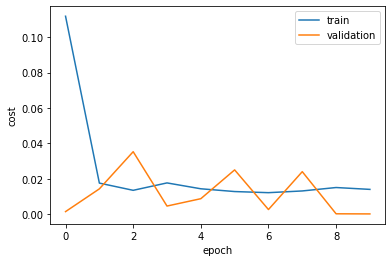

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "validation"])
plt.xlabel("epoch")
plt.ylabel("cost")

visaulisasi hasil prediksi dengan data test

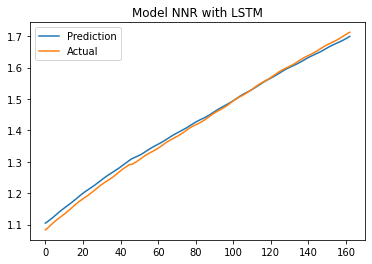

In [24]:
y_predicted = model.predict(x_test)

plt.plot(y_predicted,label='Prediction')
plt.plot(y_test,label='Actual')
plt.title("Model NNR with LSTM")
plt.legend()

**2.Linear Regression**

In [33]:
model_linear_reg = LinearRegression().fit(x_train.reshape(-1,window), y_train)
model_linear_reg.score(x_train.reshape(-1,window), y_train)

0.999999732772761

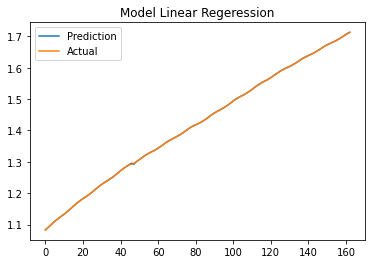

In [34]:
y_predicted = model_linear_reg.predict(x_test.reshape(-1,window))

plt.plot(y_predicted, label='Prediction')
plt.plot(y_test, label='Actual')
plt.title("Model Linear Regeression")
plt.legend()

**3.SVR**

In [38]:
model_svr = SVR().fit(x_train.reshape(-1,window), y_train)
model_svr.score(x_train.reshape(-1,window), y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9938395409724174

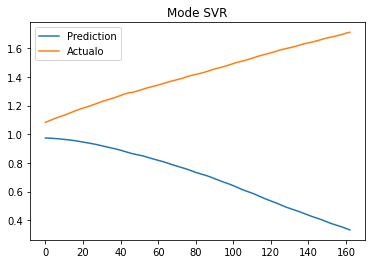

In [39]:
y_predicted = model_svr.predict(x_test.reshape(-1,window))

plt.plot(y_predicted, label="Prediction")
plt.plot(y_test, label="Actualo")
plt.title("Mode SVR")
plt.legend()

# **Evalution**

dalam hal ini saya membuat fungsi untuk menggunakan nilai sebelumnya yang dihitung untuk digunakan sebagai entri ke prediksi berikutnya, sehingga kami dapat membuat deret waktu dengan nilai prediksi!

In [27]:
def predict_future_lstm(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(1,window,1)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)

def predict_future(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(-1,window)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)


n adalah jumlah satuan waktu yang saya prediksi

In [28]:
n = 100
target_model_scaled = predict_future_lstm(target_scaled, model, window, n=n)
target_model_linear_scaled = predict_future(target_scaled,model_linear_reg,window,n=n)
target_model_svr_scaled = predict_future(target_scaled,model_svr,window,n=n)

membuat data visualisaso setiap model

In [29]:
extra_dates = pd.date_range(df['date'].iloc[-1], periods=n + 1, freq='MS')
extra_dates = extra_dates.to_series().reset_index(drop=True).iloc[1:]
all_dates = pd.concat((df['date'], extra_dates), ignore_index=True)

visualisasi nilai train,tes, dan prediksi

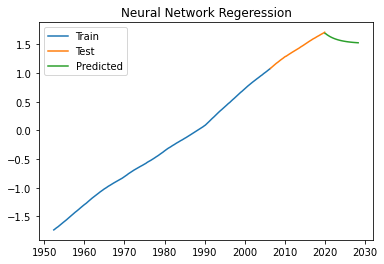

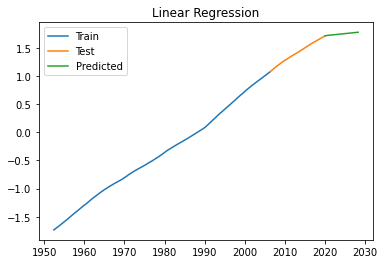

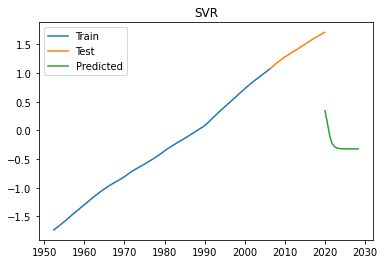

In [30]:
def future_chart(future_target, y_train, y_test, x_date, window, title=''):
    original_target_size = len(y_train) + len(y_test)
    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train')
    sns.lineplot(x=x_date[len(y_train) + window: original_target_size + window], y=y_test[:,0], label='Test')
    sns.lineplot(x=x_date[original_target_size + window:], y=future_target[original_target_size:,0], label='Predicted')
    plt.title(label=title)
    plt.show()

future_chart(target_model_scaled,  y_train, y_test, all_dates, window, title='Neural Network Regeression')
future_chart(target_model_linear_scaled,  y_train, y_test, all_dates, window, title='Linear Regression')
future_chart(target_model_svr_scaled,  y_train, y_test, all_dates, window, title='SVR')

Jadi Di dapatkan bahwa dalam kasus dataset ini model yang terbaik di pake adalah Model Linear Regeression dari Neural Network regeression dan  SVR